# **Importing the libraries and define functions**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import itertools
#Parameter estimation
import optunity
import optunity.metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#SVR model
from sklearn.svm import SVR
#Feature scaling (Normalize)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#Noise reduction
from scipy.signal import savgol_filter
#Metrics
from scipy import stats
import sklearn.metrics as metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
#Visualize
import matplotlib.pyplot as plt
#File management
import os.path
import os, glob
import csv

Group of functions that reverse the standar scale, and normalization

In [2]:
def inverse_scaler(y_true, y_pred):
    y_true = y_true.reshape(-1,1)
    y_pred = y_pred.reshape(-1,1)
    y_true = sc_y.inverse_transform(y_true)
    y_pred = sc_y.inverse_transform(y_pred)
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()
    return y_true, y_pred

def inverse_normalize(x):
    for i, ob in enumerate(x):
        x[i]=(x[i]*(dataset['CO2'].max()-dataset['CO2'].min())+dataset['CO2'].min())
    return x

This function allow us to get the percentage to split the data in order to get the number of instances equivalent to a period of time (1 hour, 3 hours...)

In [3]:
def get_percentage(x, total):
    return ((x*100)/total)/100

Function that plots the predictions and the true values to compare them, and saves the results as csv.

In [4]:
def plot_accuracy(y_true, y_pred, xax_, step_, t_s):
    y_true = inverse_normalize(y_true)
    y_pred = inverse_normalize(y_pred)
    y_true = y_true.reshape(-1,1)
    y_pred = y_pred.reshape(-1,1)
    xax=xax_
    ig=plt.figure(figsize=(25, 12), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(y_true[0::xax], label='y_true')
    plt.plot(y_pred[0::xax], label='y_pred')
    min_y_bound = min(min(y_true), min(y_true))
    max_x_bound = max(max(y_true), max(y_true))
    step = step_
    plt.yticks(np.arange(min_y_bound, max_x_bound+step, step))
    plt.xticks(np.arange(0, y_true[0::xax].size+1,1), np.arange(0, y_true.size+1,1)[0::xax], rotation=90)
    plt.xlabel('Instances')
    plt.ylabel('CO2')
    plt.legend()
    plt.grid()
    plt.savefig("graphs/"+filename+"_{test_s:.4f}test_score{score:.3f}_g{g:.2f}_C{C:.2f}.png".format(test_s=t_s, score = test_score, g = gamma, C=C))
    fname = "predictions/"+filename+"_{test_s:.4f}test_score{score:.3f}_g{g:.2f}_C{C:.2f}.csv".format(test_s=t_s, score = test_score, g = gamma, C=C)
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    df = pd.DataFrame({"y_true" : y_true, "y_pred" : y_pred})
    df.to_csv(fname, index=False, sep=";")

In order to do the parameter optimization we need to import the libraries and the metrics in which we are going to measure the quality of the model:


*   R2_Score \begin{equation} R2 = 1-\frac{\sum \left (  y_{i}-\check{y_{i}} \right )^2}{\sum \left (  y_{i}-\bar{y_{i}} \right )^2} \end{equation}
*   Mean Squared Error (MSE) \begin{equation} MSE = \frac{1}{n} \sum \left ( y_{i}-\check{y_{i}}\right )^{2} \end{equation}
*   Mean Absolute Error (MAE) \begin{equation} MAE = \frac{1}{n} \sum \left |  y_{i}-\check{y_{i}}\right | \end{equation}
*   Root Mean Squared Error (RMSE) \begin{equation} RMSE = \sqrt{MSE} = \sqrt{\frac{1}{n} \sum \left ( y_{i}-\check{y_{i}}\right )^{2}} \end{equation}





In [5]:
def regression_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    r2=metrics.r2_score(y_true, y_pred)
    metrics_dic = {'ev':round(explained_variance,4), 'r2':round(r2,4), 'mae':round(mean_absolute_error,4), 'mse':round(mse,4), 'rmse':round(np.sqrt(mse),4)}
    return metrics_dic   

# **Importing the dataset**
Read the dataset, and establish as index the date. This allows us to split data between different dates.

In [6]:
filename = 'livingroom_K4'
dataset = pd.read_csv('data/'+filename+'.csv', delimiter=";", parse_dates=True)
dataset['Time'] = pd.to_datetime(dataset.Time) 
dataset['Timestamp'] = pd.to_datetime(dataset.Time,format='%d-%m-%Y %H:%M') 
dataset.index = dataset.Timestamp

# **Data visualization**
### Plot the data in order to visualize possible outliers

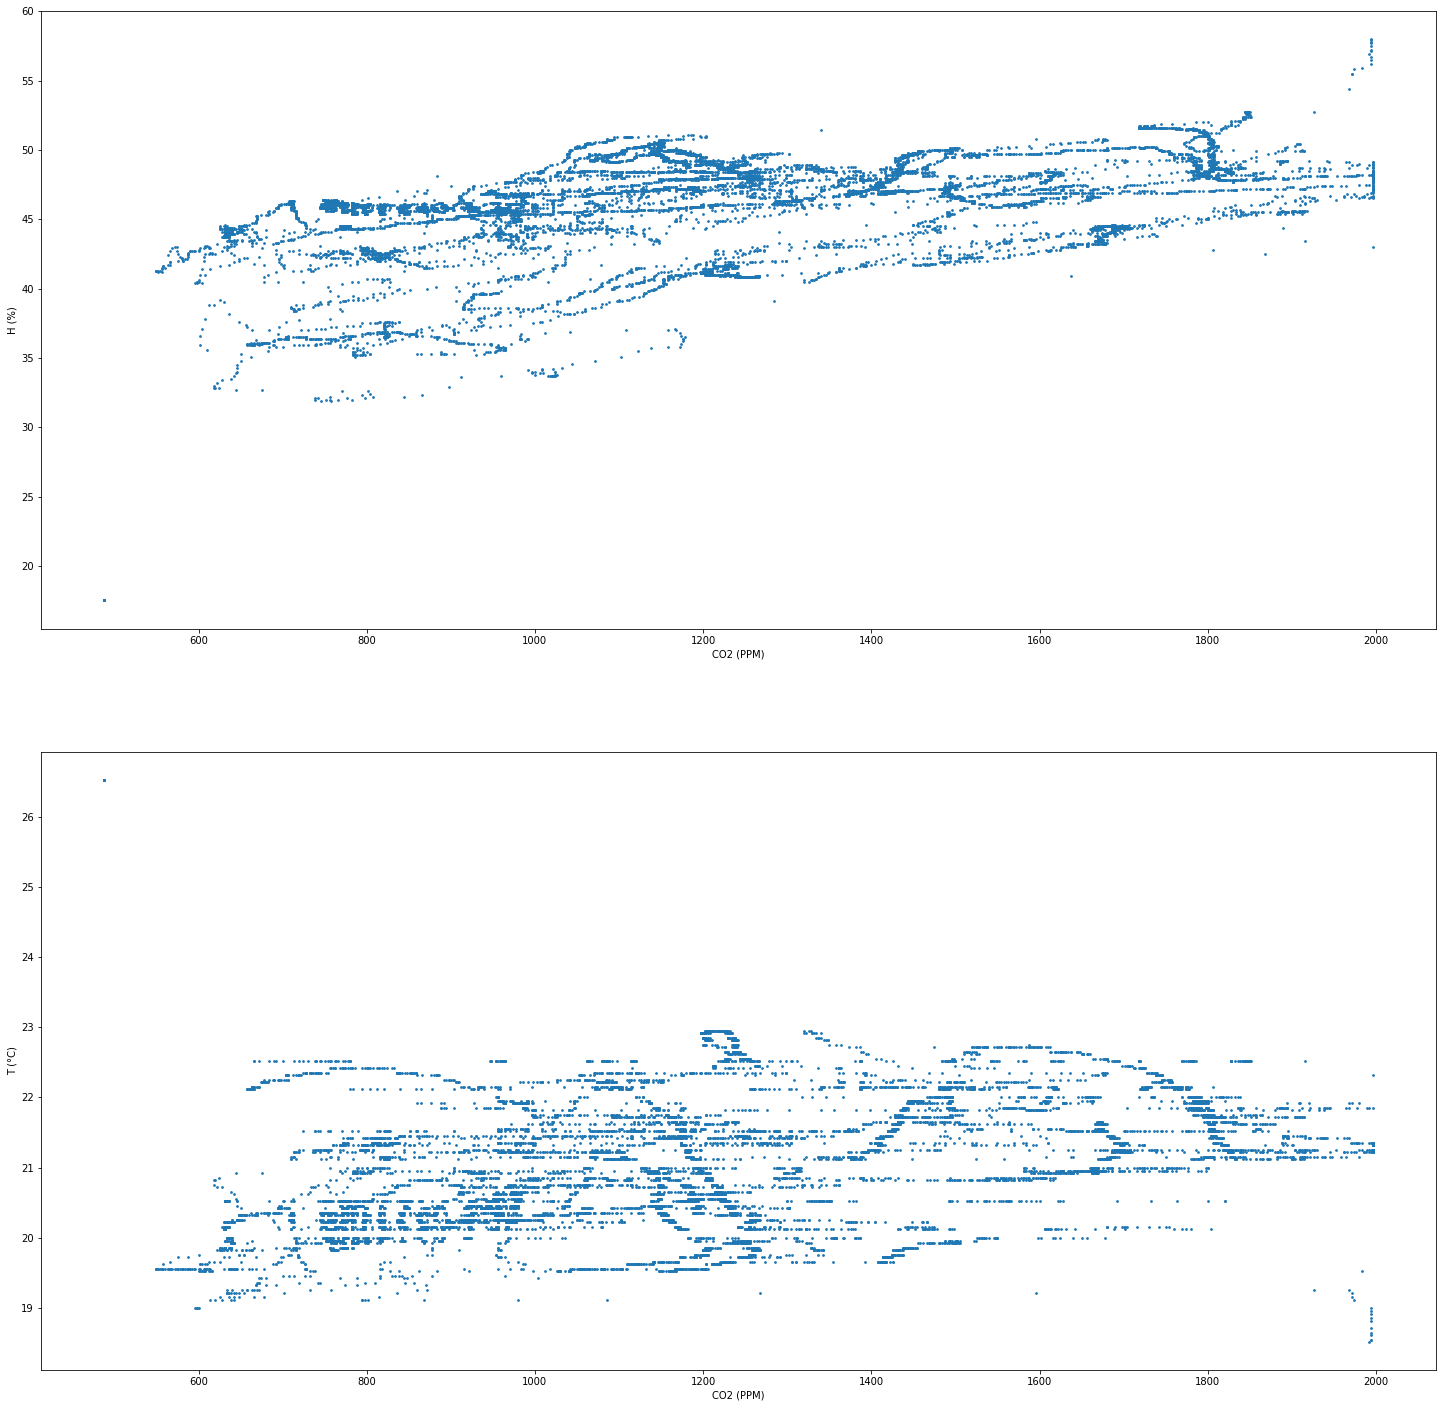

In [7]:
fig, ax = plt.subplots(2,1,figsize=(25,25))
ax[0].scatter(dataset['CO2'], dataset['H'], s=3, cmap="Blues")
ax[0].set_xlabel('CO2 (PPM)')
ax[0].set_ylabel('H (%)')
ax[1].scatter(dataset['CO2'], dataset['T'], s=3, cmap="Blues")
ax[1].set_xlabel('CO2 (PPM)')
ax[1].set_ylabel('T (°C)')
plt.show()

As we can see, it's possible to see some outliers, so we have to work to detect and delete them so we get better predictions
### Plot the data with and without applying the Savitzky-golay filter

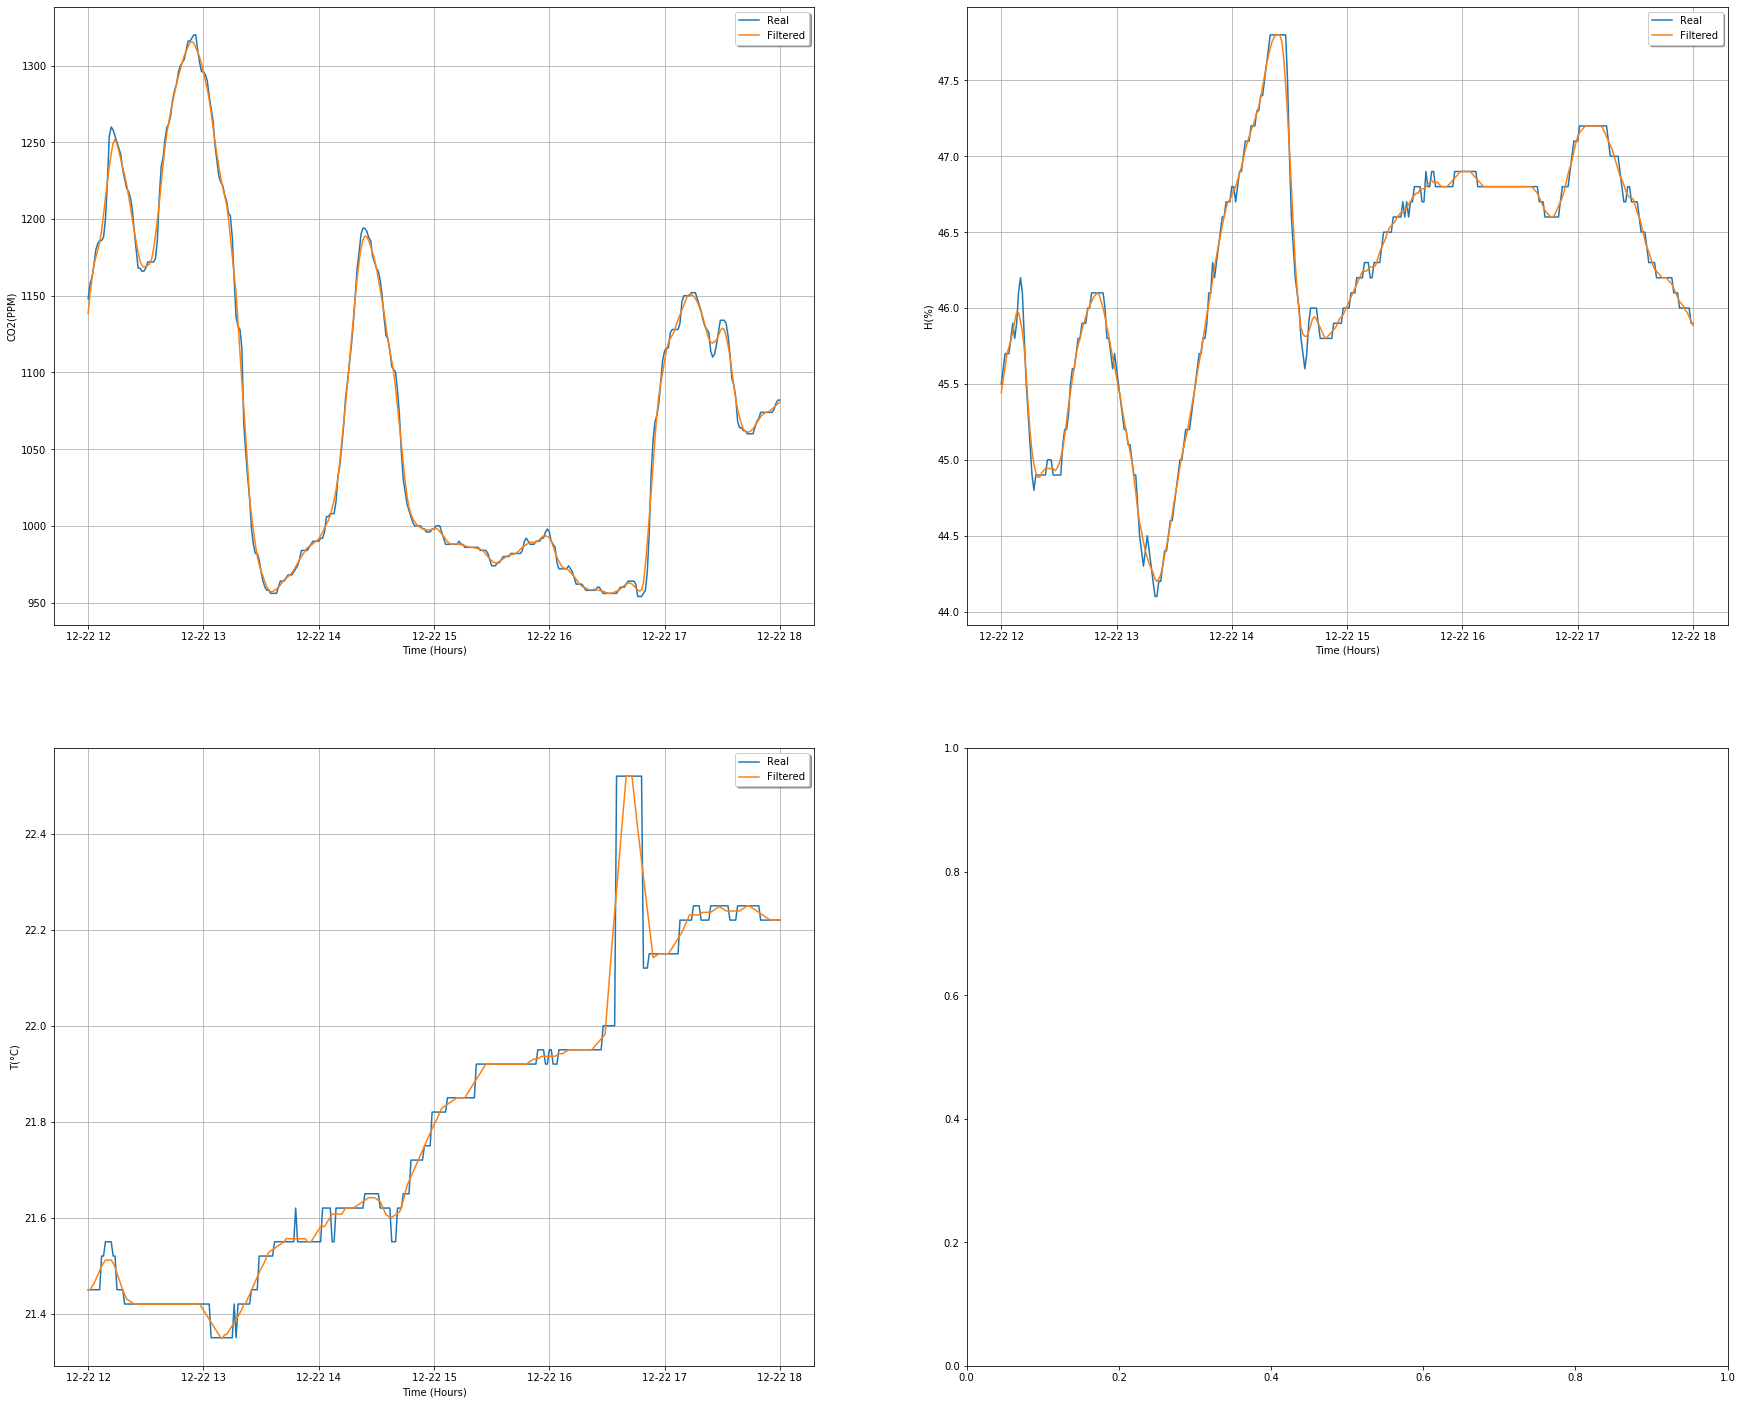

In [8]:
dataset['CO2_']= savgol_filter(dataset['CO2'], 7, 1)
dataset['H_']= savgol_filter(dataset['H'], 7, 1)
dataset['T_']= savgol_filter(dataset['T'], 11, 1)
fig, axs = plt.subplots(2,2,figsize=(30,25))

start = '22-Dec-2018 12:00:00'
end = '22-Dec-2018 18:00:00'

axs[0][0].plot(dataset['CO2'][start:end])
axs[0][0].plot(dataset['CO2_'][start:end])
axs[0][0].legend(('Real', 'Filtered'), loc='upper right', shadow=True)
axs[0][0].set_xlabel('Time (Hours)')
axs[0][0].set_ylabel('CO2(PPM)')
plt.sca(axs[0][0])
plt.grid()

axs[0][1].plot(dataset['H'][start:end])
axs[0][1].plot(dataset['H_'][start:end])
axs[0][1].legend(('Real', 'Filtered'), loc='upper right', shadow=True)
axs[0][1].set_xlabel('Time (Hours)')
axs[0][1].set_ylabel('H(%)')
plt.sca(axs[0][1])
plt.grid()

axs[1][0].plot(dataset['T'][start:end])
axs[1][0].plot(dataset['T_'][start:end])
axs[1][0].legend(('Real', 'Filtered'), loc='upper right', shadow=True)
axs[1][0].set_xlabel('Time (Hours)')
axs[1][0].set_ylabel('T(°C)')
plt.sca(axs[1][0])
plt.grid()

dataset=dataset.drop(['CO2_', 'H_', 'T_'], axis=1)

# **Data preprocessing**

### Detect and remove outliers
Calculate Z-score to remove outliers which their Z-score is lower than 3.
\begin{equation}
    z = \frac{x-\mu}{\sigma}
\end{equation}
Print the shape to see how many instances are removed.

In [9]:
original_shape = dataset.shape
print(original_shape)

(14936, 5)


In [10]:
z = np.abs(stats.zscore(dataset.iloc[:,1:4]))
threshold = 3
dataset = dataset[(z < threshold).all(axis=1)]

In [11]:
removed_outliers = dataset.shape
print(original_shape[0]-removed_outliers[0], "instances were detected as outliers and removed")

138 instances were detected as outliers and removed


### Data splitting
We split all the dataset into train, validation and test.

In [12]:
X = dataset.iloc[:,2:4].values.astype(float)
y = dataset.iloc[:,1:2].values.astype(float)
print("Shapes train (X,y): \t", X.shape,y.shape, "\nData \nX:", X, "\ny:", y)

Shapes train (X,y): 	 (14798, 2) (14798, 1) 
Data 
X: [[42.5     19.42019]
 [42.2     19.52019]
 [41.5     19.55   ]
 ...
 [43.8     21.22019]
 [43.8     21.22019]
 [43.8     21.22019]] 
y: [[1004.]
 [ 998.]
 [ 956.]
 ...
 [ 978.]
 [ 978.]
 [ 978.]]


### Check linear data
Check if data is linear: Use LinearRegression, if R2 score is lower than 0, data is nonlinear

In [13]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression().fit(X, y)
y_pred, y_true = regressor.predict(X), y
regression_results(y_true, y_pred)

{'ev': 0.4079,
 'r2': 0.4079,
 'mae': 205.2102,
 'mse': 64632.4155,
 'rmse': 254.2291}

### Data filtering (Noise reduction)
Filter data with Savitzky-golay filter. The windows length is set to 7, and the polynomial order to 1.

In [14]:
dataset['CO2']= savgol_filter(dataset['CO2'], 7, 1)
dataset['H']= savgol_filter(dataset['H'], 7, 1)
dataset['T']= savgol_filter(dataset['T'], 7, 1)

### Data normalization
In order to normalize the data we apply to the dataset the next formula:
\begin{equation}
    X_{norm} = \frac{X-X_{min}}{X_{max}-X_{min}}
\end{equation}

In [15]:
dataset_normalized = ((dataset-dataset.min())/(dataset.max()-dataset.min()))

### Variable preparation
Get the percentages of the different test sizes (3 hour, 6 hour, 1 day, 3 day), to test the trained model in different ranges of time.

In [16]:
one_hour = get_percentage(60, dataset.shape[0])
three_hour = get_percentage(180, dataset.shape[0])
six_hour = get_percentage(360, dataset.shape[0])
one_day = get_percentage(1440, dataset.shape[0])
three_day = get_percentage(3*1440, dataset.shape[0])

test_s = [one_hour, three_hour, six_hour, one_day, three_day]

Create the dataframe which we will export later, to save the scores and parameters of each model.

In [17]:
output = pd.DataFrame(columns=['ev', 'r2', 'mae', 'mse', 'rmse', 'gamma', 'C', 'test_size'])

### Data and class
Now prepare the X and y variables.

In [18]:
def split_XY(dataset_normalized):
    X = dataset_normalized.iloc[:,2:4].values.astype(float)
    y = dataset_normalized.iloc[:,1:2].values.astype(float)
    return X,y

### Data scalation
Scale the data in order to get better accuracy

In [19]:
sc_X = StandardScaler()
sc_y = StandardScaler()

def scale_data(X,y):
    X = sc_X.fit_transform(X)
    y = sc_y.fit_transform(y)
    y = np.ravel(y)
    return X,y

### Split data between train and test

In [20]:
def split_data(X, y):
    return train_test_split(X, y, train_size=0.7, test_size=test_s[i], random_state=55)

### Parameter estimation

GridSearchCV is a tool offered by Scikit-learn which help us to set different parameters and it will select and train the model with the best combination of those parameters.

In [21]:
def estimate_parameters(X_train, y_train):
    gamma_range = [100, 150]
    C_range = [3]
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': gamma_range, 'C': C_range }]
    grid_regressor = GridSearchCV(SVR(), tuned_parameters, scoring='r2', cv=3)
    grid_regressor.fit(X_train, y_train)
    return grid_regressor

### Model train and creation
Create the model with the optimal parameters.

In [22]:
def create_model(C, gamma, X_train, y_train):
    regressor = SVR(kernel='rbf',
                    C=C,
                    gamma=gamma,
                    epsilon=0.125)
    regressor.fit(X_train,y_train)
    return regressor

### Data prediction

In [23]:
def predict_data(regressor, X_, y_):
    y_true, y_pred = y_, regressor.predict(X_)
    return y_true, y_pred

# Execute the code
Execute all the functions created before in order to obtain the model and the scores.

In [29]:
for i,o in enumerate(test_s):

    #Split between traind and test
    print('Data split (Traind and test)')
    print('\tTest instances: ', round(dataset.shape[0]*o,0))
    print('\tTrain instances: ', round(dataset.shape[0]*0.7),0)

    #Split between X and y
    X, y = split_XY(dataset_normalized)

    #Data normalize
    print('Data scale')
    X,y = scale_data(X,y)
    
    X_train, X_, y_train, y_ = split_data(X,y)

    #Parameter estimation
    print('Parameter tuning')
    grid_regressor=estimate_parameters(X_train, y_train)

    #Save best parameters
    C = grid_regressor.best_params_['C']
    gamma = grid_regressor.best_params_['gamma']
    print('Training model...')

    #Model creation
    regressor=create_model(C, gamma, X_train, y_train)

    #Predict test
    print('Predicting...')
    y_true, y_pred = predict_data(regressor, X_, y_)

    #Inverse the data scale
    y_true,y_pred = inverse_scaler(y_true, y_pred)

    print('Saving results...\n')
    #Get scores and save them
    results_test=regression_results(y_true,y_pred)
    test_score = results_test['r2']
    results_test['gamma']=gamma
    results_test['C']=C
    results_test['test_size']=round(test_s[i],4)
    test_dic = pd.DataFrame(results_test, index=[0])
    output = output.append(test_dic, ignore_index=True)

    #Plot the graphs
    plot_accuracy(y_true, y_pred, int(y_true.size/50), 100, test_s[i])

print('Done')
print(output)
output.to_csv('configuration_models/models_.csv', mode='a', header=False)

Data split (Traind and test)
	Test instances:  60.0
	Train instances:  10359 0
Data scale
Parameter tuning
Training model...
Predicting...
Saving results...

Data split (Traind and test)
	Test instances:  180.0
	Train instances:  10359 0
Data scale
Parameter tuning
Training model...


KeyboardInterrupt: 

Manually remove the memory occupied with the garbage collector to not freeze the computer.

In [ ]:
import gc
gc.collect()